In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bson.json_util import dumps
from pymongo import MongoClient
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier

In [55]:
client = MongoClient("mongodb://localhost:27017/")
db = client["db"]
collection = db["dataset"]

data_path = "dataset_100k.csv"
mongodb_dataset = pd.read_csv(data_path, encoding="latin")


records = mongodb_dataset.to_dict("records")
collection.delete_many({})
collection.insert_many(records)
print(f"Collection size: {collection.estimated_document_count()}")

Collection size: 101766


In [56]:
documents = collection.find()
data = pd.DataFrame(list(documents))

data.drop("_id", axis=1, inplace=True)

data_info = data.info()
data_head = data.head()

print(data_info, data_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   max_glu_serum             5346 non-null    object
 2   A1Cresult                 17018 non-null   object
 3   metformin                 101766 non-null  object
 4   repaglinide               101766 non-null  object
 5   nateglinide               101766 non-null  object
 6   chlorpropamide            101766 non-null  object
 7   glimepiride               101766 non-null  object
 8   acetohexamide             101766 non-null  object
 9   glipizide                 101766 non-null  object
 10  glyburide                 101766 non-null  object
 11  tolbutamide               101766 non-null  object
 12  pioglitazone              101766 non-null  object
 13  rosiglitazone             101766 non-null  object
 14  acar

In [7]:
data = pd.read_csv("dataset_100k.csv")

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

# Prepare the data for the Severity Prediction Model
features = data[
    [
        "Temperature(F)",
        "Visibility(mi)",
        "Humidity(%)",
        "Pressure(in)",
        "Wind_Speed(mph)",
        "Precipitation(in)",
        "Amenity",
        "Bump",
        "Crossing",
        "Give_Way",
        "Junction",
        "No_Exit",
        "Railway",
        "Roundabout",
        "Station",
        "Stop",
        "Traffic_Calming",
        "Traffic_Signal",
    ]
]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
features_imputed = imputer.fit_transform(features)

# Encode boolean features as integers
features_imputed = pd.DataFrame(features_imputed, columns=features.columns)
bool_cols = [
    "Amenity",
    "Bump",
    "Crossing",
    "Give_Way",
    "Junction",
    "No_Exit",
    "Railway",
    "Roundabout",
    "Station",
    "Stop",
    "Traffic_Calming",
    "Traffic_Signal",
]
features_imputed[bool_cols] = features_imputed[bool_cols].astype(int)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Define the target variable
target = data["Severity"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Fit a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
evaluation = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(evaluation).transpose()

/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,166.00000
2,0.797059,0.999812,0.886997,15941.00000
3,0.250000,0.000294,0.000588,3398.00000
4,0.000000,0.000000,0.000000,495.00000
accuracy,0.796950,0.796950,0.796950,0.79695
macro avg,0.261765,0.250027,0.221896,20000.00000
weighted avg,0.677771,0.796950,0.707081,20000.00000


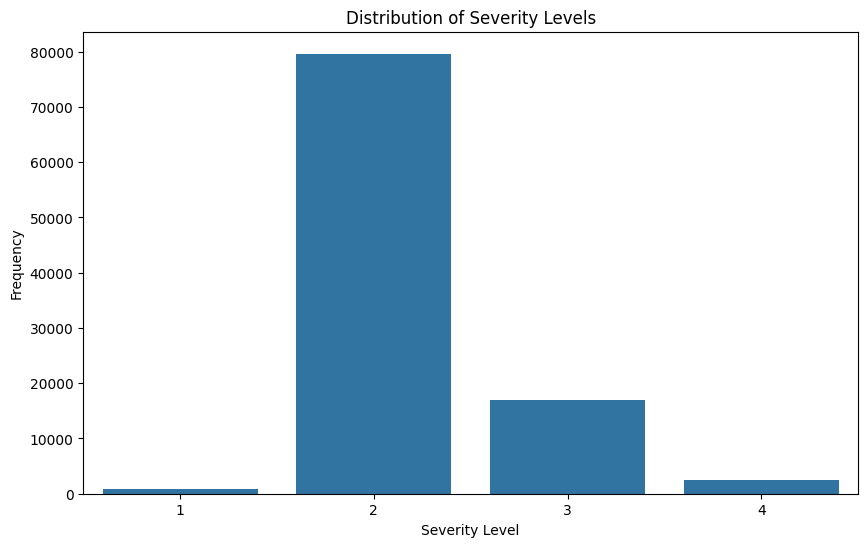

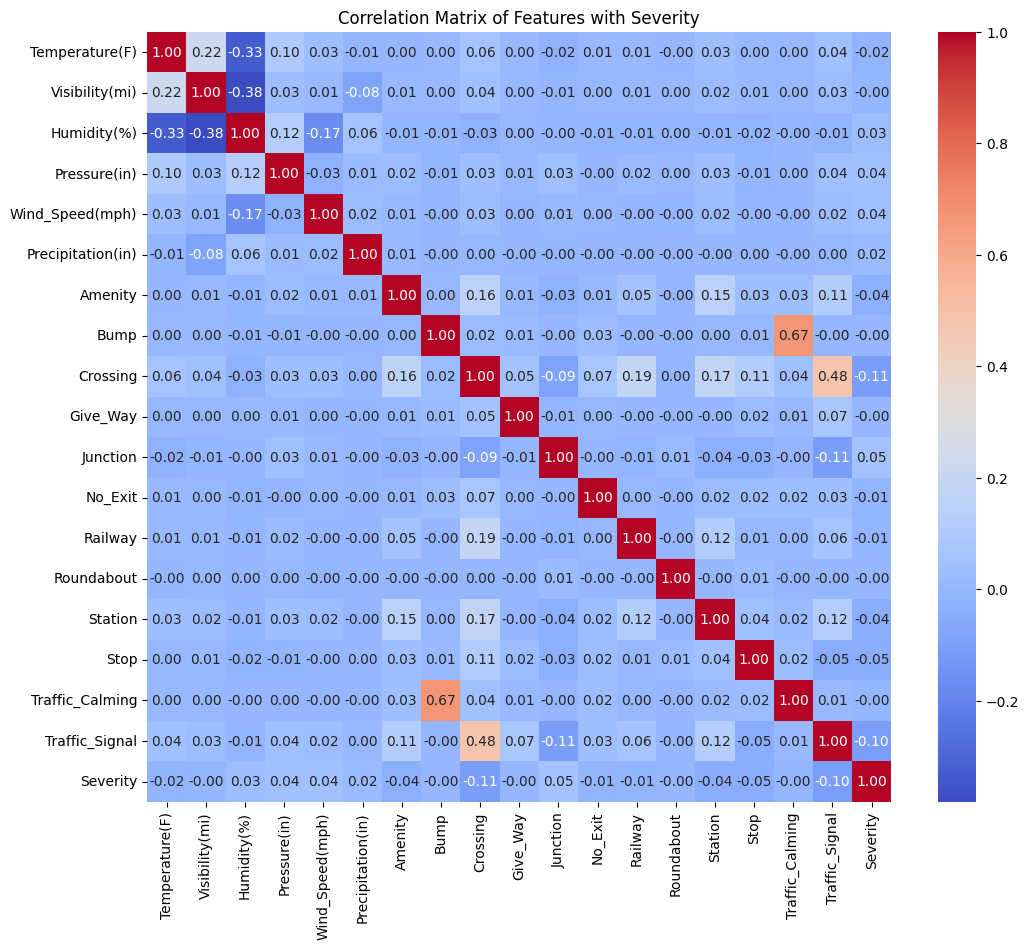

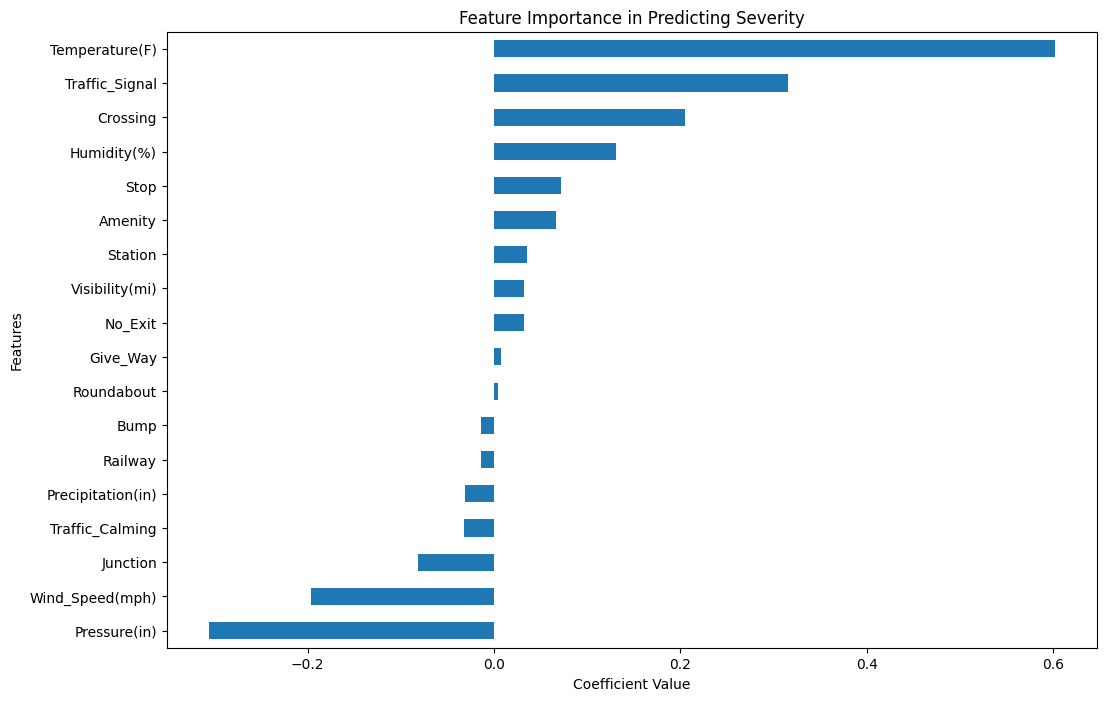

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of severity levels in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=data["Severity"])
plt.title("Distribution of Severity Levels")
plt.xlabel("Severity Level")
plt.ylabel("Frequency")
plt.show()

# Plotting a correlation matrix of the features
plt.figure(figsize=(12, 10))
corr = features_imputed.join(data["Severity"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features with Severity")
plt.show()

# Plotting the importance of each feature in the logistic regression model
plt.figure(figsize=(12, 8))
feature_importance = pd.Series(
    model.coef_[0], index=features_imputed.columns
).sort_values()
feature_importance.plot(kind="barh")
plt.title("Feature Importance in Predicting Severity")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

Model Explanation for the Severity Prediction using Logistic Regression

The Logistic Regression model we developed is designed to predict the severity of traffic incidents based on various environmental and traffic-related features. This model is particularly insightful as it helps us understand the conditions under which traffic incidents become more severe, allowing for better planning and intervention.

1. Feature Importance in Predicting Severity:

Description: This chart highlights the coefficient values of each feature used in the Logistic Regression model. These values represent the impact each feature has on predicting the severity of traffic incidents, with positive values increasing the likelihood of higher severity and negative values indicating a decrease.

Key Features: As we can see, Temperature(F), Traffic_Signal, and Crossing are among the top predictors. High temperature often correlates with increased vehicle performance issues or driver fatigue, leading to more severe accidents. Similarly, incidents occurring at or near traffic signals and crossings are typically more severe due to higher vehicle concentrations and potential pedestrian involvement.

Use in Presentation: This plot is crucial as it quantifies the influence of each feature on the severity predictions. Understanding these can help traffic management authorities to focus on specific conditions or areas that significantly impact incident severity.\

2. Correlation Matrix of Features with Severity:

Description: This heatmap shows how each feature is correlated with the severity of traffic incidents, as well as the inter-correlations among the features themselves.

Insights: We observe that Humidity(%) and Visibility(mi) have a noticeable correlation with severity, where higher humidity levels and lower visibility conditions tend to be associated with more severe accidents. The inter-correlations, such as that between Traffic_Signal and Junction, help in understanding the overlapping influence of traffic control features on severity.

Use in Presentation: This visualization will be used to discuss how different environmental and infrastructural factors correlate with the severity of accidents. It aids in identifying potentially redundant features or those that might require separate analysis due to multicollinearity.

3. Distribution of Severity Levels:

Description: This bar chart illustrates the frequency of each severity level within the dataset. It provides a visual representation of the class imbalance present, with severity level 2 being the most common.

Observations: The predominance of level 2 severity incidents can bias the model toward predicting this class more frequently, potentially at the expense of accuracy for less common severity levels.

Use in Presentation: This chart is essential for discussing the challenges in model training due to imbalanced data. It underpins the importance of employing techniques such as SMOTE for oversampling minority classes or adjusting class weights in the modeling process to achieve more balanced predictions.

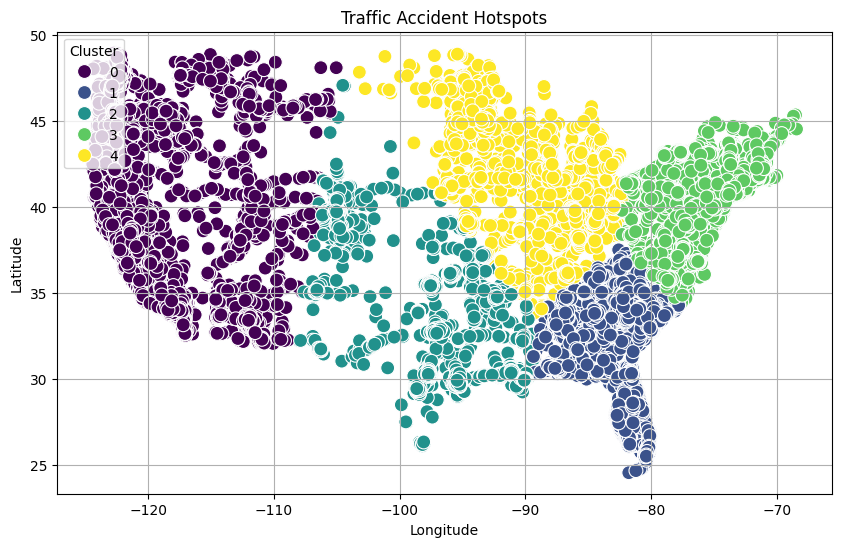

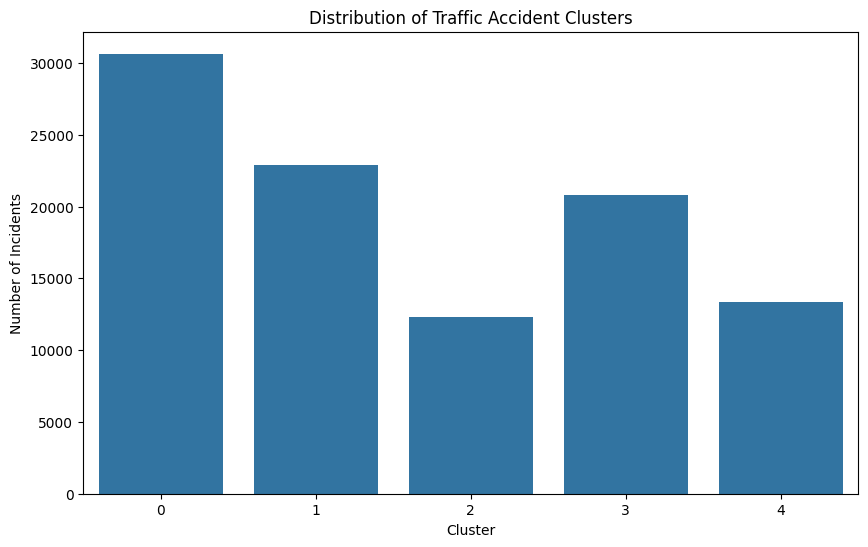

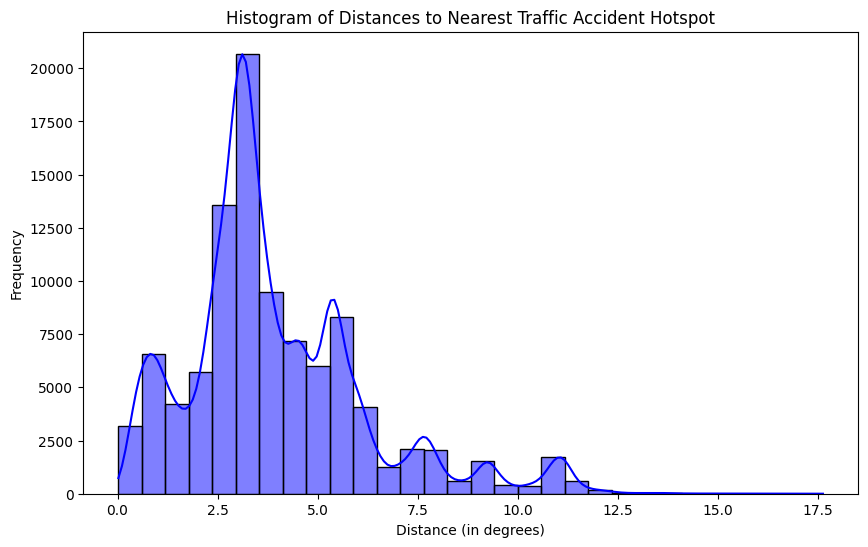

array([[  37.08352012, -118.79242391],
       [  30.94400418,  -82.01051181],
       [  32.38109527,  -96.71986568],
       [  39.79466821,  -76.03461602],
       [  41.19204994,  -88.52268776]])

In [10]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare data for accident hotspot analysis using geographical coordinates
coords = data[["Start_Lat", "Start_Lng"]].dropna()

# Using KMeans to find clusters (hotspots)
kmeans = KMeans(n_clusters=5, random_state=0).fit(coords)
coords["Cluster"] = kmeans.labels_

# Plotting the clusters on a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Start_Lng", y="Start_Lat", hue="Cluster", palette="viridis", data=coords, s=100
)
plt.title("Traffic Accident Hotspots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", loc="upper left")
plt.grid(True)
plt.show()

# Calculate the centroids of each cluster to identify the exact hotspot locations
centroids = kmeans.cluster_centers_

# Plotting the distribution of clusters
plt.figure(figsize=(10, 6))
sns.countplot(x=coords["Cluster"])
plt.title("Distribution of Traffic Accident Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Incidents")
plt.show()

# Creating a distance to nearest hotspot feature
coords["Distance_to_Hotspot"] = np.min(
    kmeans.transform(coords[["Start_Lat", "Start_Lng"]]), axis=1
)

# Plotting distance to nearest hotspot
plt.figure(figsize=(10, 6))
sns.histplot(coords["Distance_to_Hotspot"], bins=30, kde=True, color="blue")
plt.title("Histogram of Distances to Nearest Traffic Accident Hotspot")
plt.xlabel("Distance (in degrees)")
plt.ylabel("Frequency")
plt.show()

centroids

The second model in our study uses clustering techniques to identify traffic accident hotspots. This analysis is crucial as it helps pinpoint geographical areas with a high frequency of incidents, which can be targeted for enhanced safety measures.

1. Traffic Accident Hotspots (Geographical Clusters):

Description: The scatter plot visualizes the geographical distribution of traffic incidents, categorized into different clusters. Each cluster represents a potential hotspot with a higher occurrence of traffic accidents.

Key Insights: The visualization reveals distinct regions where traffic incidents are concentrated. For instance, we can observe significant clusters in densely populated or heavily trafficked areas. These clusters are color-coded, making it easy to identify and differentiate between the areas.

Use in Presentation: This plot is essential for identifying regions that may require more attention from traffic management authorities. It helps in visualizing the spread and concentration of accident-prone areas, guiding targeted interventions like improved road infrastructure, enhanced traffic signal systems, or increased patrolling.

2. Distribution of Traffic Accident Clusters:

Description: This bar chart provides a breakdown of the number of incidents across each identified cluster. It highlights the frequency of accidents in each hotspot.

Key Insights: Some clusters exhibit a significantly higher number of incidents compared to others. This variation helps prioritize areas that might benefit the most from increased safety measures and resource allocation.

Use in Presentation: This visualization supports strategic planning by quantifying the traffic accident occurrences in each cluster. It enables policymakers and city planners to allocate resources more efficiently, ensuring that the areas with the most severe issues are addressed first.

3. Histogram of Distances to Nearest Traffic Accident Hotspot:

Description: The histogram shows the distribution of distances from each reported incident to the nearest traffic accident hotspot. It measures how far each incident occurs from central clusters, giving a sense of the geographical spread related to each hotspot.

Key Insights: The histogram indicates a high frequency of incidents close to the hotspots, with the frequency tapering off as the distance increases. This pattern suggests that the most critical areas for interventions are within a few degrees of the identified hotspots.

Use in Presentation: This plot is crucial for understanding the effective range of influence around each hotspot. It helps in planning the extent of safety measures, ensuring that they cover not just the hotspots but also the surrounding areas where incidents are likely to occur.


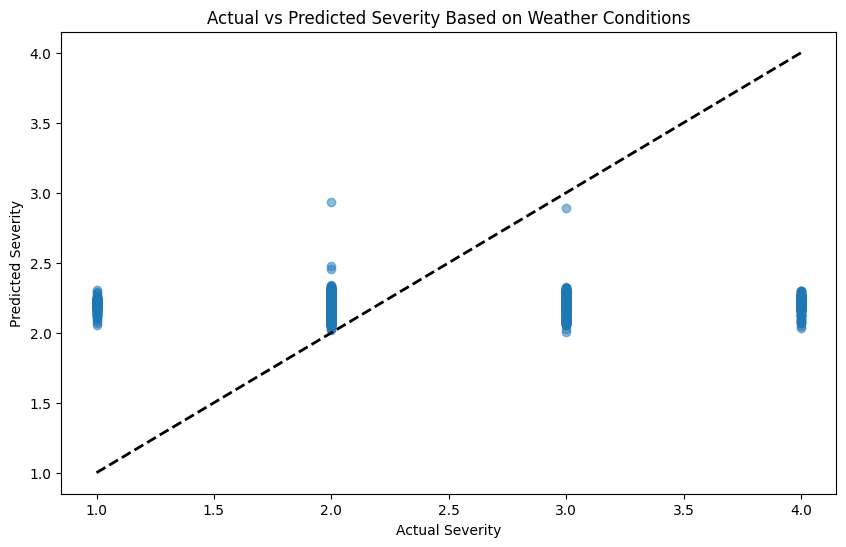

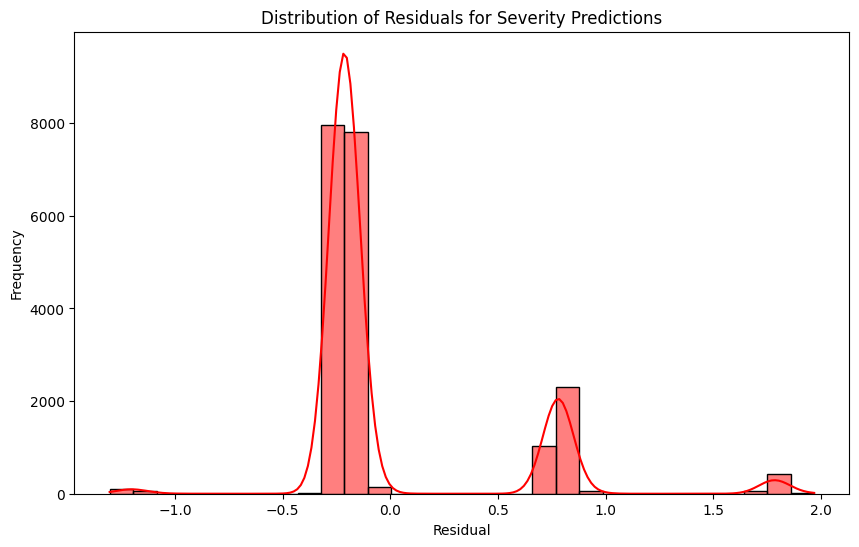

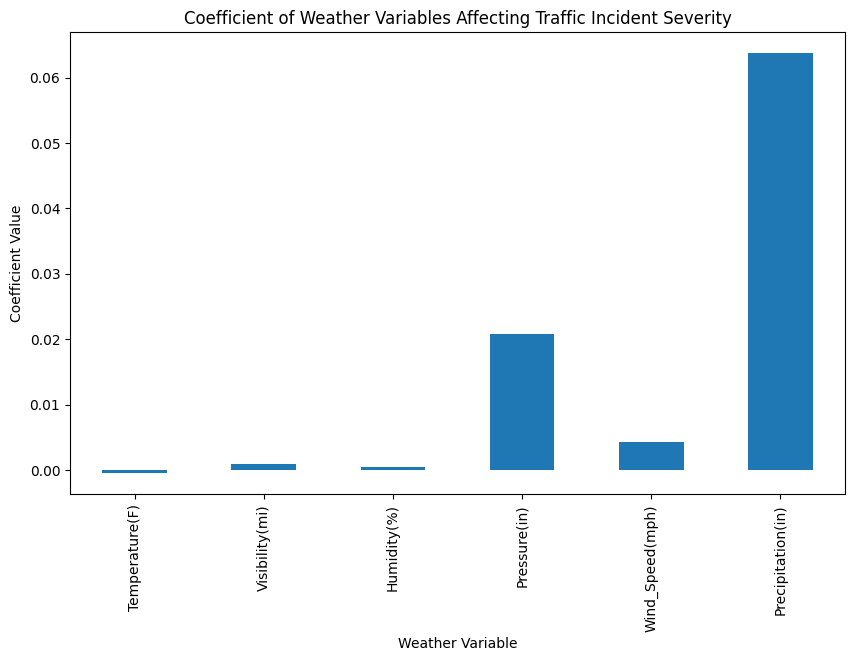

In [11]:
from sklearn.linear_model import LinearRegression

# Prepare data for Impact of Weather on Traffic Conditions model
weather_features = data[
    [
        "Temperature(F)",
        "Visibility(mi)",
        "Humidity(%)",
        "Pressure(in)",
        "Wind_Speed(mph)",
        "Precipitation(in)",
    ]
]
weather_features_imputed = imputer.fit_transform(weather_features)
weather_features_imputed = pd.DataFrame(
    weather_features_imputed, columns=weather_features.columns
)

# Response variable could be the number of incidents in similar conditions, we simplify by assuming severity as response for direct impact
weather_target = data["Severity"]

# Splitting data
WX_train, WX_test, Wy_train, Wy_test = train_test_split(
    weather_features_imputed, weather_target, test_size=0.2, random_state=42
)

# Fit a Linear Regression model to predict severity based on weather conditions
weather_model = LinearRegression()
weather_model.fit(WX_train, Wy_train)

# Predicting on the test set
Wy_pred = weather_model.predict(WX_test)

# Scatter plot for actual vs predicted severity based on weather conditions
plt.figure(figsize=(10, 6))
plt.scatter(Wy_test, Wy_pred, alpha=0.5)
plt.xlabel("Actual Severity")
plt.ylabel("Predicted Severity")
plt.title("Actual vs Predicted Severity Based on Weather Conditions")
plt.plot(
    [Wy_test.min(), Wy_test.max()], [Wy_test.min(), Wy_test.max()], "k--", lw=2
)  # Reference line
plt.show()

# Plotting residuals
residuals = Wy_test - Wy_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="red")
plt.title("Distribution of Residuals for Severity Predictions")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Coefficients of the model to see the impact of each weather variable on severity
weather_model_coeffs = pd.Series(weather_model.coef_, index=weather_features.columns)
weather_model_coeffs.plot(kind="bar", figsize=(10, 6))
plt.title("Coefficient of Weather Variables Affecting Traffic Incident Severity")
plt.ylabel("Coefficient Value")
plt.xlabel("Weather Variable")
plt.show()

The third model examines how various weather conditions influence the severity of traffic incidents. This analysis is vital as it enables better understanding and forecasting of the risks associated with different weather scenarios.

1. Actual vs Predicted Severity Based on Weather Conditions:

Description: This scatter plot demonstrates the relationship between the actual and predicted severity of traffic incidents based on weather conditions. Each dot represents an incident, plotted to show how the predicted severity compares against the actual severity.

Key Insights: The plot reveals that while some predictions align closely with the actual outcomes (dots near the dashed line), there are notable deviations, especially for higher severity levels. These discrepancies suggest that the model may require additional refinement to accurately capture how weather conditions impact incident severity.

Use in Presentation: This visualization is crucial for demonstrating the model's current predictive accuracy and the areas where it may fall short. It serves as a basis for discussing how model enhancements or integration of additional data types could improve prediction accuracy.

2. Distribution of Residuals for Severity Predictions:

Description: This histogram plots the residuals, which are the differences between the predicted and actual severity scores. It assesses the model's prediction errors across all incidents.

Key Insights: The residuals are primarily centered around zero, which is ideal, but the spread of the data indicates variability in the model’s performance. The presence of multiple peaks suggests the model's responses to various scenarios might be inconsistent.

Use in Presentation: This chart is essential for evaluating the model's performance, showing where the model is most and least accurate. Discussing this plot helps explain the model's reliability and where improvements might be made, such as incorporating more nuanced weather data or adjusting the model parameters.

3. Coefficient of Weather Variables Affecting Traffic Incident Severity:

Description: This bar chart ranks the influence of different weather variables on the predicted severity of traffic incidents, represented by the size of their coefficients in the regression model.

Key Insights: Precipitation emerges as the most significant predictor of increased severity, followed by temperature. The smaller influence of variables like visibility and wind speed might indicate these factors have a less direct impact on incident severity or that their effects are more complex than currently modeled.

Use in Presentation: This visualization highlights the differential impact of various weather conditions on traffic incident severity. It can be used to discuss how targeted measures, such as alert systems for heavy precipitation or extreme temperatures, could be implemented to mitigate risk.